# which countries share common number of trade partners

In [1]:
import dask.dataframe as dd

In [2]:
from dask.distributed import Client, progress

client = Client(n_workers=2, threads_per_worker=2, memory_limit='5GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57755,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 9.31 GiB
Comm: tcp://127.0.0.1:57771,Total threads: 2
Dashboard: http://127.0.0.1:57773/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:57758,


In [3]:
directory_path = './trade data/trade_data/'

# Generate the file pattern for the years 1975 to 2000
file_pattern = directory_path + 'BACI_HS12_Y{year}_V202001.csv'

file_patterns = [file_pattern.format(year=year) for year in range(2018, 2019)]

df = dd.read_csv(file_patterns,assume_missing=True)

df

,t,i,j,k,v,q
npartitions=5,,,,,,
,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [4]:
import pandas as pd
products = pd.read_csv('./trade data/trade_data/product_codes_HS12_V202001.csv',encoding='latin-1')
products = products.rename(columns={"code":"k"})
df_wdes = df.merge(products)

countries = pd.read_csv('./trade data/trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv('./trade data/trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"j","country_name_full":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

In [5]:
import dask.dataframe as dd
from dask_ml.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df_wdes is your Dask DataFrame

# Grouping by exporter country code (i) and counting unique importer country codes (j)
exporter_counts = df_wdes.groupby('i')['j'].nunique().compute().reset_index()
exporter_counts.columns = ['country_code', 'exporter_partners']

# Grouping by importer country code (j) and counting unique exporter country codes (i)
importer_counts = df_wdes.groupby('j')['i'].nunique().compute().reset_index()
importer_counts.columns = ['country_code', 'importer_partners']

# Merging both DataFrames to get total partners for each country
partner_counts = dd.merge(exporter_counts, importer_counts, on='country_code', how='outer').fillna(0)

# Total partners for each country
partner_counts['total_partners'] = partner_counts['exporter_partners'] + partner_counts['importer_partners']

In [6]:
# Selecting features for clustering
features = partner_counts[['exporter_partners', 'importer_partners', 'total_partners']]

# Standardizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Creating Dask array
X = dd.from_array(scaled_features, columns=features.columns)

D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

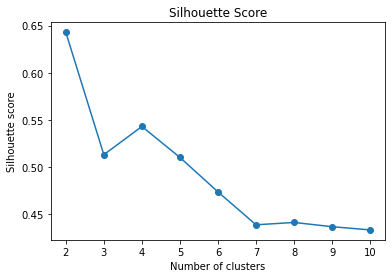

In [7]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score')
plt.show()


D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


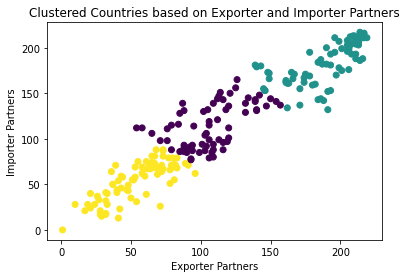

Cluster 1 Center: Exporter Partners=107.02941176470588, Importer Partners=114.20588235294117, Total Partners=221.23529411764707
Cluster 2 Center: Exporter Partners=188.92105263157893, Importer Partners=182.68421052631578, Total Partners=371.60526315789474
Cluster 3 Center: Exporter Partners=53.6923076923077, Importer Partners=53.51282051282048, Total Partners=107.20512820512818


In [9]:
# Fitting K-means clustering model
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

# Getting cluster labels
cluster_labels = kmeans.labels_.compute()

# Adding cluster labels to DataFrame
partner_counts['cluster'] = cluster_labels

# Visualizing the clusters
plt.scatter(partner_counts['exporter_partners'], partner_counts['importer_partners'], c=cluster_labels, cmap='viridis')
plt.xlabel('Exporter Partners')
plt.ylabel('Importer Partners')
plt.title('Clustered Countries based on Exporter and Importer Partners')
plt.show()

# Analyzing the clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1} Center: Exporter Partners={center[0]}, Importer Partners={center[1]}, Total Partners={center[2]}")

In [11]:
# Assuming 'partner_counts' DataFrame has country codes and cluster labels as before

# Get the list of countries in cluster 0
countries_in_cluster_0 = partner_counts[partner_counts['cluster'] == 0]['country_code'].tolist()

print("Countries in Cluster 0:")
print(countries_in_cluster_0)

Countries in Cluster 0:
[4.0, 8.0, 12.0, 20.0, 24.0, 31.0, 50.0, 51.0, 60.0, 68.0, 84.0, 96.0, 104.0, 108.0, 116.0, 120.0, 132.0, 144.0, 178.0, 192.0, 204.0, 214.0, 222.0, 231.0, 242.0, 266.0, 268.0, 270.0, 275.0, 304.0, 320.0, 324.0, 340.0, 352.0, 364.0, 368.0, 388.0, 398.0, 400.0, 417.0, 450.0, 462.0, 466.0, 478.0, 496.0, 498.0, 499.0, 508.0, 524.0, 558.0, 591.0, 600.0, 634.0, 690.0, 694.0, 704.0, 716.0, 729.0, 760.0, 780.0, 788.0, 800.0, 807.0, 854.0, 858.0, 860.0, 862.0, 894.0]


In [15]:
# Merge with country names (assuming exporter country code is 'i' and importer country code is 'j')
country_names_exporter = df_wdes[['i', 'name_i']].drop_duplicates().compute()
country_names_importer = df_wdes[['j', 'name_j']].drop_duplicates().compute()
partner_counts = dd.merge(partner_counts, country_names_exporter, left_on='country_code', right_on='i', how='left').drop(columns='i')
partner_counts = dd.merge(partner_counts, country_names_importer, left_on='country_code', right_on='j', how='left').drop(columns='j')
partner_counts['country_name'] = partner_counts['name_i'].fillna(partner_counts['name_j'])

# Analyzing the clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(cluster_centers):
    print(f"\nCluster {i+1} Center: Exporter Partners={center[0]:.2f}, Importer Partners={center[1]:.2f}, Total Partners={center[2]:.2f}")
    cluster_countries = partner_counts[partner_counts['cluster'] == i]['country_name']
    print("Countries in this cluster:")
    for country in cluster_countries:
        print(country)


Cluster 1 Center: Exporter Partners=107.03, Importer Partners=114.21, Total Partners=221.24
Countries in this cluster:
Afghanistan
Albania
Algeria
Andorra
Angola
Azerbaijan
Bangladesh
Armenia
Bermuda
Plurinational State of Bolivia
Belize
Brunei Darussalam
Myanmar
Burundi
Cambodia
Cameroon
Cabo Verde
Sri Lanka
Congo
Cuba
Benin
Dominican Republic
El Salvador
Ethiopia
Fiji
Gabon
Georgia
Gambia
State of Palestine
Greenland
Guatemala
Guinea
Honduras
Iceland
Iran
Iraq
Jamaica
Kazakhstan
Jordan
Kyrgyzstan
Madagascar
Maldives
Mali
Mauritania
Mongolia
Republic of Moldova
Montenegro
Mozambique
Nepal
Nicaragua
Panama
Paraguay
Qatar
Seychelles
Sierra Leone
Viet Nam
Zimbabwe
Sudan
Syria
Trinidad and Tobago
Tunisia
Uganda
The Former Yugoslav Republic of Macedonia
Burkina Faso
Uruguay
Uzbekistan
Venezuela
Zambia

Cluster 2 Center: Exporter Partners=188.92, Importer Partners=182.68, Total Partners=371.61
Countries in this cluster:
Argentina
Australia
Austria
Bahrain
Belgium-Luxembourg
Bosnia Herzegov

Cluster 1:
Center: Exporter Partners=107.03, Importer Partners=114.21, Total Partners=221.24
Interpretation: This cluster consists of countries with moderate levels of both exporter and importer partners, with a total number of partners averaging around 221. These countries engage in trade activities with a moderate number of partners, indicating a balanced trade network.
Countries in this cluster: Afghanistan, Albania, Algeria, Angola, Azerbaijan, Bangladesh, and many others.

Cluster 2:
Center: Exporter Partners=188.92, Importer Partners=182.68, Total Partners=371.61
Interpretation: This cluster represents countries with high levels of both exporter and importer partners, with a total number of partners averaging around 372. These countries have extensive trade networks, being both significant exporters and importers on the global stage.
Countries in this cluster: Argentina, Australia, Belgium, Brazil, Canada, China, France, Germany, India, Japan, and many others.

Cluster 3:
Center: Exporter Partners=53.69, Importer Partners=53.51, Total Partners=107.21
Interpretation: This cluster comprises countries with relatively low levels of both exporter and importer partners, with a total number of partners averaging around 107. These countries have limited engagement in international trade, either due to their small size, isolation, or economic factors.
Countries in this cluster: American Samoa, Antigua and Barbuda, Bahamas, Barbados, Bhutan, and many others.

These interpretations provide a high-level overview of the characteristics of each cluster based on the number of exporter and importer partners. Further analysis could delve into the specific trade patterns, economic factors, and geopolitical considerations influencing each cluster

In [16]:
from sklearn.decomposition import PCA

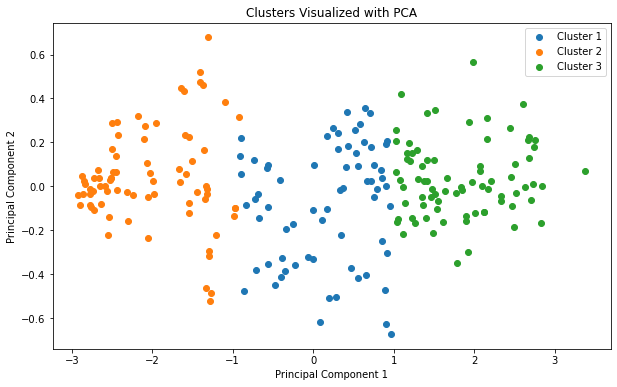

In [17]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features)

# Plotting the clusters
plt.figure(figsize=(10, 6))
for cluster in range(3):
    plt.scatter(X_pca[cluster_labels == cluster, 0], X_pca[cluster_labels == cluster, 1], label=f'Cluster {cluster+1}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualized with PCA')
plt.legend()
plt.show()

The PCA plot shows the distribution of the countries in the three clusters after reducing the dimensionality of the features:

Cluster 1 (Blue): Positioned towards the center-left of the graph. This cluster consists of countries with moderate trade activity, both as exporters and importers. The central location in the PCA plot suggests these countries are closer to the average for both trade dimensions.

Cluster 2 (Orange): Found on the far left of the graph. The countries in this cluster have higher trade activity, indicating they have a significant number of trading partners, both as exporters and importers.

Cluster 3 (Green): Plotted on the far right of the graph. This cluster represents countries with the least trade activity, both as exporters and importers. The rightmost position suggests their values for both trading dimensions are significantly lower than the other clusters.
In summary, the PCA visualization helps distinguish the clusters by projecting them into two dimensions based on the variance in the dataset. It visually represents the relative positions of the clusters, indicating the trade relationships that distinguish them.